In [1]:
#Load some modules etc
%matplotlib inline
import matplotlib.pyplot as plt
from cycler import cycler

from sympy import *
import scipy as sc
import numpy as np
init_printing()

# Introduction

In this notebook I run thorugh the theory asociated with the microbial competition experiments. The basic idea is to develop a model which describes the temperature dependence of respiratory flux in communities with interacting species. This requires the model to not only describe the temperature dependence of metabolism itself (as classic MTE does) but also the change in flux that occurs due to the temperature dependence of species interactions. 

First I show how the temperature dependence of total respiratory flux of a population can be approximated assuming a temperature dependence of growth rate. I then describe growth in communities in multiple non-interacting species before moving to communities with species interactions. For now all of these models describe communities in the exponential growth phase where I assume that resources are non-limited (as is the case in the experiments). 

# Single Species model

First I will show how the temperature dependence of total respiratory flux of a population can be derived from the temperature dependence of its mass-specific respiration and carbon uptake. The total respiratory flux of carbon for a single species popualtion $s$ is equal to it's mass specific flux times its biomass

\begin{align}
    R_s = C_s \tilde{R}_s
\end{align}

where $R_s$ is the total respiratory flux of species $s$, $C_s$ the carbon biomass and $\tilde{R}$ the mass-specific respiratory flux. In order to determine the temperature dependence of total flux we need to work out the temperature dependence of both the biomass and mass-specific respiration. 

## Temperature dependence of respiration

Obtaining the temperature dependence of respiration ($\tilde{R}_s$) is easy as we can simply use the boltzmann equation to represent the respiratory rate:

\begin{align}
    \tilde{R}_s(T) = \tilde{R_s}_0 e^{-E_\tilde{R_s} (T_r - T_{ra})}
\end{align}

where $\tilde{R}_s(T)$ is the respiration at temperature $T$, $\tilde{R}_{s_0}$ is respiration at some reference temperature, $E_{\tilde{R}_s}$ is the the tempeature sensitivty of respiration and $T_r$ and $T_{ra}$ are the Boltzmann corrected temperature and reference temperature respectively. Thus the equation for total flux becomes:

\begin{align}
    R_s = C_s \tilde{R_s}_0 e^{-E_\tilde{R_s} (T_r - T_{ra})}
\end{align}

## Temperature dependence of biomass

Obtaining the temperature dependence of carbon biomass is more difficult as biomass is not directly dependent on temperature. Instead temperature affects the rate of biomass change in the population meaning that its effects are time dependent. Thus, we must also account for time when looking at the temperature dependence of biomass. 

To do this we need to consider how biomass evolves over time and develop a model for microbe growth. I start with the basic observation that change in carbon biomass is simply the carbon uptake minus carbon loss:

\begin{align}
    \frac{dC}{dt} = \text{uptake} - \text{loss}
\end{align}

### Uptake

A common approach to model the uptake of carbon in microbes is to use a Michaelis-Menten type model:

\begin{align}
    \mu = \mu_{max} \frac{C}{k_s + C}
\end{align}

where $\mu$ is the uptake rate (and $\mu_{max}$ the maximum uptake rate), $C$ is the amount of carbon avalible in the enviroment and $k_s$ is the half saturation constant at which carbon uptake is 50% of the maximum. Given that we are modeling popualtions in the exponential growth phase we assume that resources are not limiting such that ${C\to\infty}$ meaning that the value of $\frac{C}{k_s + C} \to 1$. Thus we can use the first order approximation to represent uptake $\mu = \mu_{max}$.

### Loss

Here I assume that the loss of carbon occurs solely via respiratory losses. In doing so I ignore mortality as it is likley small in regards to other carbon fluxes in the system. I start by seperating respiratory losses into two components, respiration for growth $R_g$ and respiration for maintenence $R_m$. At any point total losses are given by the sum of these terms with $R = R_g + R_m$. Thus the total equation for biomass change becomes:

\begin{align}
    \frac{dC}{dt} &= \mu - R \\ &= \mu - R_g - R_m
\end{align}

Respiration for growth occurs as carbon is assimilated into biomass via an imperfect process which results in some carbon loss. This rate of carbon loss is proportional to the growth rate such that $R_g = (1 - \epsilon) \mu$ where $\epsilon = \frac{bio}{\mu}$ (i.e the proportion of carbon uptake used for new biomass growth). subsituting this into the equation above gives:

\begin{align}
    \frac{dC}{dt} &= \mu - (1 - \epsilon) \mu - R_m \\
                  &= \mu - \mu + \epsilon \mu - R_m \\
                  &= \epsilon \mu - R_m
\end{align}

Expressing these rates as mass specific terms we can rewrite the change in biomass as:

\begin{align}
    \frac{1}{C}\frac{dC}{dt} = \epsilon \tilde{\mu} - \tilde{R}_m
\end{align}

We can use seperation of variables to get the general solution of this equation:

\begin{align}
    C(t) &= C_0 e^{t (\epsilon \tilde{\mu} - \tilde{R_m}) } \\
         &= C_0 e^{t \epsilon \tilde{\mu}} e^{- t \tilde{R_m}}
\end{align}

To get the temperature dependence of this process we need only substitute the Boltzmann equation for the $\tilde{\mu}$ and $\tilde{R_m}$ terms which gives:

\begin{align}
    C(t,T) = C_0 e^{t \epsilon \tilde{\mu}_0 e^{-E_{\tilde{\mu}} (T_r - T_{ra})}} e^{- t  \tilde{R_m}_0 e^{-E_{\tilde{R_m}} (T_r - T_{ra})}}
\end{align}

In this form it is not possible to get an expression for the temperature dependence of growth (a single coefficent of $(T_r-T_{ra})$) due to the double exponentials. We can take the log and use a taylor expansion around the point $T_r = T_{ra}$ to get around this:

In [53]:
t,e,u_0,E_u,R_0,E_R,C_0,T_r,T_ra = var("t,\epsilon,u_0,E_u,R_0,E_R,C_0,T_r,T_ra")

ep = e
gr = u_0 * exp(-E_u * (T_r - T_ra))
re = R_0 * exp(-E_R * (T_r - T_ra))

C = C_0 * exp (t * (ep * gr) - (t* re) )

C_log=  expand_log(log(C),force=true)
C_approx = exp(C_log.series(T_r,T_ra,2).removeO())
C_approx

Combining the approximation above with the temperature dependence of respiration we can rewrite the equation for total respiration as:

\begin{align}
    R_s \approx C_0 e^{-\tilde{R_m}_{s_0} t + \tilde{\mu}_{s_0} \epsilon_s t +
                (E_{\tilde{R_m}_s} \tilde{R_m}_{s_0} t -
                 E_{\mu_s} \mu_{s_0} \epsilon_s t)(T_r - T_{ra})} 
    \tilde{R}_{s_0} e^{-E_{\tilde{R_m}_s} (T_r - T_{ra})}
\end{align}

which means we can get the coefficent of $(T_r - T_{ra})$ for total respiration:

\begin{align}
    E_{R_s} &\approx -E_{\tilde{R}_s} + E_{\tilde{R_m}_s} \tilde{R_m}_{s_0}  t - E_{\tilde{\mu_s}} \tilde{\mu_s}_0 t \epsilon_s\\
            &\approx -E_{\tilde{R_m}_s} - E_{\tilde{R_g}_s} + E_{\tilde{R_m}_s} \tilde{R_m}_{s_0} t - E_{\tilde{\mu_s}} \tilde{\mu_s}_0 t \epsilon_s
\end{align}

Looking at this equation we can see several interesting features of the model:

- Increasing the sensitivity of $E_\tilde{R_s}$ will not always increase the sensitvity of total respiration due it it's negative effects on growth rates. This will depend on how it increases though (i.e. we can increase growth respiration or maintenance) 

- Increasing the time ($t$) will increase the temperature sensitvity of total respiration (due to the multiplication of growth and respiration but only if $E_{\tilde{R}_s} \tilde{R}_{s_0} < E_{\mu_s} \mu_{s_0} \epsilon_s$

# Multispecies model

In this section I will show how we can derive the temperature dependence of total system flux in multispecies communities. I first show how this is possible in two species communities without interactions before generalising to the n-species case and communities where interactions occur. 

## Non-interacting communities

In a system with two species and no interactions the total flux in the system can simply be described as the sum of the species level fluxes:

\begin{align}
        R_{tot} &= R_1 + R_2 \\
                &= C_1 \tilde{R}_1 + C_2 \tilde{R}_2 \\
                &= C_{0_1} \tilde{R}_{1_0} e^{ \gamma_1 + E_{R_1}(T_r - T_{ra})} +
                   C_{0_2} \tilde{R}_{2_0} e^{ \gamma_2 + E_{R_2}(T_r - T_{ra})}
\end{align}

where $\gamma_s = -\tilde{R}_{s_0} \epsilon_s t + \mu_{s_0} \epsilon_s t$ and $E_{R_s} = -E_\tilde{R_s} + E_{\tilde{R}_s} \tilde{R}_{s_0} \epsilon_s t - E_{\mu_s} \mu_{s_0} \epsilon_s t$. 

We can use the taylor expansion trick to convert this into a single TPC:

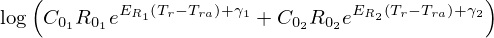

In [3]:
C_01,C_02,R_01,R_02 = var("C_{0_1},C_{0_2},R_{0_1},R_{0_2}")
T_r,T_ra = var("T_r,T_ra")

e1,e2,t = var("\epsilon_1,\epsilon_2,t")
u_01,u_02 = var("\mu_{0_1},\mu_{0_2}")
E_R1, E_R2, E_u1, E_u2 = var("E_{R_1}, E_{R_2}, E_{u_1}, E_{u_2}")

g1,g2 = var("\gamma_1,\gamma_2")

E_R_1 , E_R_2 = var("E_{R_1},E_{R_2}")

R1 = C_01 * R_01 * exp(g1 + E_R_1*(T_r-T_ra))
R2 = C_02 * R_02 * exp(g2 + E_R_2*(T_r-T_ra))


R_tot = R1 + R2
log(R_tot)

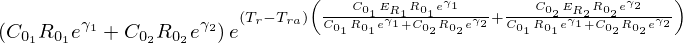

In [4]:
exp((log(R_tot).series(T_r,T_ra,2).removeO()))

This can simplified to the N-species case giving:

\begin{align}
    R_{tot} \approx \sum_{s=0}^{n} C_{0_s} R_{0_s} e^{\gamma_s} 
              e^{(T_r - T_ra) \left(\frac{C_{0_s} R_{0_s} e^{\gamma_s} E_{R_s}}
              {\sum_{p=0}^{n} C_{0_p} R_{0_p} e^{\gamma_p}} \right)}
\end{align}

with $\gamma_s$ and $E_{R_s}$ having the same values as above. From this equation we can see that in a non-interacting community (i.e. where rates of biomass growth are independent) the temperature dependence of total respiratory flux is simply the weighted average of each populations flux:

\begin{align}
    E_{R_{tot}} \approx \sum_{s=0}^{n} \frac{C_{0_s} R_{0_s} e^{\gamma_s} E_{R_s}}
                                            {\sum_{p=0}^{n} C_{0_p} R_{0_p} e^{\gamma_p}}
\end{align}

## Interacting communities

The real challenge here is the question of how the hell we include species interactions? The obvious way to do it is to go back to the original growth model and add another term. There needs to be some assumption of mechanism in this model as interactions must either modify the allocation to growth $\epsilon$ or the total uptake $\mu$. Given that we are assuming that resources are unlimited in this scenario it is reasonable to assume that the value of $\mu$ is constant. Normally this term would be represented using a michelas-menten model but 

# Extra stuff

## Temperature dependent growth

More realistic is the case where growth rate depends on temperature in addition to respiration. Though this may take several forms here I assume that it can be described using the Arrhenius equation:

\begin{align}
 r = r_0 e^{-E_r (T_r - T_{ra})}
\end{align}

thus the total equation becomes: 

\begin{align}
    R_s = C_0 e^{t r_0 e^{-E_r (T_r - T_{ra})}} \tilde{R}_0 e^{-E_R (T_r - T_{ra})}
\end{align}

This means that the temperature dependence can no longer be described simply by the dependence of respiration. The double exponential form of the growth component prevents us from combining the two temperature terms straight away. To get arround this we can approximate the temperature dependence of the carbon biomass growth term ($C_s = C_0 e^{rt}$) by preforming a taylor series expansion around $T_r = T_{ra}$:

In [2]:
C_0,t,T_r,T_ra,E_r,r_0 = var("C_0,t,T_r,T_ra,E_r,r_0")

r = r_0 * exp(-E_r * (T_r - T_ra))
grow = C_0 * exp(t*r)

grow

In [3]:
grow_log = log(grow)
approx_grow = exp(grow_log.series(T_r,T_ra,2).removeO())
approx_grow

So the temperature dependence of biomass at time $t$ can be approximated as $-E_r r_0 t$. We can look at the quality of this apporoximation by looking at the next term of the taylor series which if the approxmiation is good, should be much smaller.

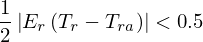

In [8]:
def taylor(n,x,a,f):
    if(n == 0):
        return(f.subs({x:a}))
    else:
        return((diff(f,x,n).subs({x:a}) / factorial(n)) * ((x-a) ** n))
    
approx = abs(taylor(2,T_r,T_ra,grow_log)/taylor(1,T_r,T_ra,grow_log)) < 0.5
approx

The value of the temperature term in this expression will range from 2.86 (at 275K) to -2.86 (at 315K). We substitute the maximum value of this into the inequality to get:

In [9]:
k = 8.617e-5
approx_T = approx.subs({T_r-T_ra:((1/(k*275)) - (1/(k*295)) )})
approx_T

In [10]:
-2 / ((1/(k*275)) - (1/(k*295)))

which when we solve for $E_r$ gives:

In [11]:
solve(approx_T)

So for the approximation to be good the temperature sensivity of growth must be smaller than $0.69$. We can test this graphically by plotting the temperature dependence of growth:

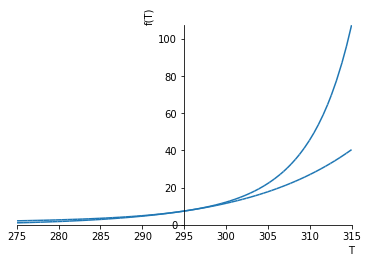

In [15]:
T = var("T")

real_growth =        grow.subs({C_0:1,r_0:1,t:2,T_r:1/(k*T),T_ra:1/(k*295),E_r:0.34})
appr_growth = approx_grow.subs({C_0:1,r_0:1,t:2,T_r:1/(k*T),T_ra:1/(k*295),E_r:0.34})

plot(real_growth,appr_growth,(T,275,315))

Needs work, i dont think the inequality is correct...

### Total respiration

using this approximation of growth we can get the temperature dependence of total respiration by substituting in the new growth term. This means we go from:

\begin{align}
    R_s = C_0 e^{t r_0 e^{-E_r (T_r - T_{ra})}} \tilde{R}_0 e^{-E_R (T_r - T_{ra})}
\end{align} 

to:

\begin{align}
    R_s &= C_{0} e^{r_{0} t} e^{- E_{r} r_{0} t (T_{r} - T_{ra})} \tilde{R}_0 e^{-E_R (T_r - T_{ra})} \\
    &= C_{0} \tilde{R}_0 e^{r_{0} t}  e^{(-E_R - E_{r} r_{0} t) (T_r - T_{ra})}
\end{align}

So the temperature dependence of total respiration can be expressed as $-E_R - E_{r} r_{0} t$ 

# Two species model

We can extend this model of total respiration to a two species system. In the simplest case with no interactions (i.e. the growth rates of both species are independent) we can write the respiration in the system as:

\begin{align}
    R_{tot} &= R_1 + R_2 \\
            &= C_1 \tilde{R}_1 + C_2 \tilde{R}_2 \\
            &= C_{0_1} \tilde{R}_{0_1} e^{r_{0_1} t}  e^{(-E_{R_1} - E_{r_1} r_{0_1} t) (T_r - T_{ra})} + 
               C_{0_2} \tilde{R}_{0_2} e^{r_{0_2} t}  e^{(-E_{R_2} - E_{r_2} r_{0_2} t) (T_r - T_{ra})}
\end{align}

we can simplify this somewhat by assuing that the starting biomass for each species is equal (i.e. $C_{0_1} = C_{0_2}$). As with the classic static model we can approximate this sum of boltzman-type equations by taking the log and using a taylor series expansion around the point $T_r = T_{ra}$: 

In [13]:
R1,R2,ER1,ER2 = var("R_{0_1},R_{0_2},E_{R_1},E_{R_2}")
r1,r2,Er1,Er2 = var("r_{0_1},r_{0_2},E_{r_1},E_{r_2}")
t,T_r,T_ra,C_0 = var("t,T_r,T_ra,C_0")


one = C_0 * R1 * exp(r1*t) * exp((-ER1 - (Er1*r1*t))*(T_r-T_ra))
two = C_0 * R2 * exp(r2*t) * exp((-ER2 - (Er2*r2*t))*(T_r-T_ra))

one + two

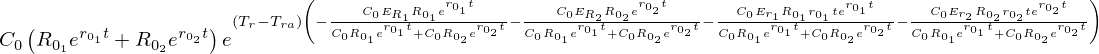

In [16]:
exp(log(one+two).series(T_r,T_ra,2).removeO())

this result can be simplified and generalised to the n-species case where:

\begin{align}
    R_{tot} = C_0 \sum_{s = 0}^{n} R_{0_s} e^{r_{0_s} t} e^{(T_r - T_{ra}) 
    \frac{C_0 \sum_{s = 0}^{n} R_{0_s} e^{r_{0_s} t} (-E_{R_s} - E_{r_s} r_{0_s} t)}
         {C_0 \sum_{s = 0}^{n} R_{0_s} e^{r_{0_s} t}} }
\end{align}

so the temperature sensitivity is the weighted average of the sensitivites of each component. 

## Species interactions

The model above does not include species interactions. We can include these interactions as changes in growth rate which can simply be included as adative effects in the growth model

\begin{align}
    \frac{dC_1}{dt} = C_1 (r_1 + \alpha_1 C_2)
    \\
    \\
    \frac{dC_2}{dt} = C_2 (r_2 + \alpha_2 C_1)
\end{align}

where $r_s$ is the mass-specific growth rate and $\alpha_s$ is the mass-specific effect on the growth of species $s$   As with the classic exponential growth model we can solve this equation to get the biomass at time $t$, $C_s(t)$ which gives:

\begin{align}
    C_1(t) &= C_0 e^{t(r_1 + \alpha_1 C_2)} \\
           &= C_0 e^{t(r_1 + \alpha_1 C_0 e^{t(r_2 + \alpha_2 C_1)})}
\end{align}

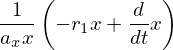

In [42]:
x,y,a1,a2,r1,r2,t = var("x,y,a_x,a_y,r1,r2,t")

y_d = Derivative(y,t)
x_d = Derivative(x,t)

d1 = (x * r1) + (a1*x*y)
d2 = (y * r2) + (a2*x*y)

y_sol = solve((d1 - x_d),y)
x_sol = solve((d2 - y_d),x)

y_sol[0]

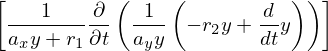

In [49]:
solve(d1-x_d.subs({x:x_sol[0]}),x)

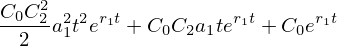

In [149]:
C1_ap = C1.series(C_2,0,3).removeO()
C1_ap

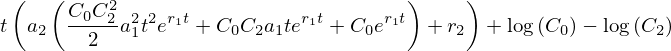

In [158]:
C2 = C_0 * exp(t*(r2 + a2* C1_ap))

expand_log(log(C2) - log(C_2),force=true)

In [47]:
collect((C_log.series(T_r,T_ra,2).removeO()),e_0)

In [62]:
simplify(exp(exp(t)) - exp(t*exp(1)))